In [2]:
import pandas as pd
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
random_state = 42

## Introduction to the Problem

In the high-stakes world of battle royale games like PlayerUnknown's Battlegrounds (PUBG), every match is a new story. While winning is the ultimate goal, a player's experience is defined by more than just their final rank. A player who gets ten kills but is eliminated early due to bad luck has a vastly different—and likely more frustrating—experience than a player who hides and survives to the end with zero kills.

This project tackles that nuanced problem. Instead of predicting long-term churn, we aim to identify **in-match frustration**.

**The central question is: Can we use a player's in-match actions (kills, damage, distance traveled) to predict their expected final placement, and then use the *error* in that prediction to quantify how frustrating their match was?**

By answering this, we can create a "Frustration Score" to identify players who are performing well but not being rewarded. This could be used by game developers to fine-tune game balance or even by players themselves to understand their own performance beyond the final scoreboard.

## The Dataset

To answer our question, we are using data from the **PUBG Finish Placement Prediction** competition on Kaggle. This dataset contains detailed statistics from over 4 million individual player performances in PUBG matches.

Link to project: [PUBG Finish Placement Prediction](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)

*To run this notebook, please download the `train_V2.csv` file from the link above and place it in the root directory of this project.*

*Note: The data file is not included in this repository due to its large size and to respect the data source's distribution policy.*

**Target Variable** Our primary goal is to predict a player's final placement. Therefore, our target variable ($y$) is:
* **`winPlacePerc`**: A continuous value from **0.0** (finished last) to **1.0** (won the match). It represents the player's rank as a percentile, providing a standardized measure of success across matches with different numbers of players.

**Features** 
From the many columns available, we will select a core set of features that best represent a player's skill, effort, and strategy during a match.

| Feature Name | Description | Data Type | Type |
| :--- | :--- | :--- | :--- |
| **`kills`** | Number of enemy players killed. | Numerical | Original |
| **`assists`** | Number of times a player assisted a teammate in a kill. | Numerical | Original |
| **`DBNOs`** | Number of times a player knocked down an enemy ("Down But Not Out"). | Numerical | Original |
| **`damageDealt`** | Total damage inflicted on opponents. | Numerical | Original |
| **`headshotKills`** | Number of kills that were headshots. | Numerical | Original |
| **`killStreaks`** | The player's longest kill streak in the match. | Numerical | Original |
| **`longestKill`** | The distance of the player's longest kill. | Numerical | Original |
| **`walkDistance`** | Total distance traveled on foot. | Numerical | Original |
| **`rideDistance`** | Total distance traveled in a vehicle. | Numerical | Original |
| **`swimDistance`** | Total distance traveled by swimming. | Numerical | Original |
| **`revives`** | Number of times a player revived a teammate. | Numerical | Original |
| **`heals`** | Number of healing items used. | Numerical | Original |
| **`boosts`** | Number of boosting items used. | Numerical | Original |
| **`weaponsAcquired`** | Number of weapons picked up. | Numerical | Original |
| **`teamKills`** | Number of times a player killed a teammate. | Numerical | Original |
| **`matchType`** | The type of match (e.g., 'squad-fpp', 'duo', 'solo'). | Categorical | Original |
| **`totalDistance`** | The sum of all travel distances (walk, ride, swim). | Numerical | Engineered |
| **`headshotRate`** | The percentage of a player's kills that were headshots. | Numerical | Engineered |
| **`itemsUsed`** | The combined total of healing and boosting items used. | Numerical | Engineered |
| **`Id`, `groupId`, `matchId`** | Unique identifiers for player, group, and match. | Categorical | Original |
| **`killPlace`** | Player's in-match rank based on number of kills. | Numerical | Original |
| **`killPoints`, `rankPoints`, `winPoints`** | Deprecated ranking points from the game's old system. | Numerical | Original |

## Data Loading and Initial Overview

In [4]:
# IMPORTANT NOTE: Our dataset contains more that 4 million rows
# so it may take a while to load it
# to speed loading times, analysts may consider using a sample of the dataset only
df = pd.read_csv('train_V2.csv')

In [5]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [6]:
print("Rows: ", df.shape[0], "\nColumns: ", df.shape[1])

Rows:  4446966 
Columns:  29


In [7]:
df.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.0,0.0000,0.000000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.0,0.0000,2.000000,33.0
damageDealt,4446966.0,130.717138,170.780621,0.0,0.0,84.2400,186.000000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.0,0.0000,1.000000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.0,0.0000,0.000000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.0,0.0000,2.000000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.0,47.0000,71.000000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.0,0.0000,1172.000000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.0,0.0000,1.000000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.0,0.0000,1.000000,20.0


In [9]:
df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

## Exploratory Data Analysis (EDA)

Let us start by observing the relationships of our features with each other and the target. That will help us get an early understanding of the behavior of our data. 

In [31]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr = df[num_cols].corr()
corr_with_target = corr['winPlacePerc'].drop('winPlacePerc').sort_values(key=abs, ascending=False)

### Understanding the Data

#### Target Variable Exploration

First we try to understand our target variable `winPlacePerc` through a heatmap. By understanding what we are trying to predict, we can identify if the target has unusual characteristics that require special handling, and check for issues like extreme skewness. 

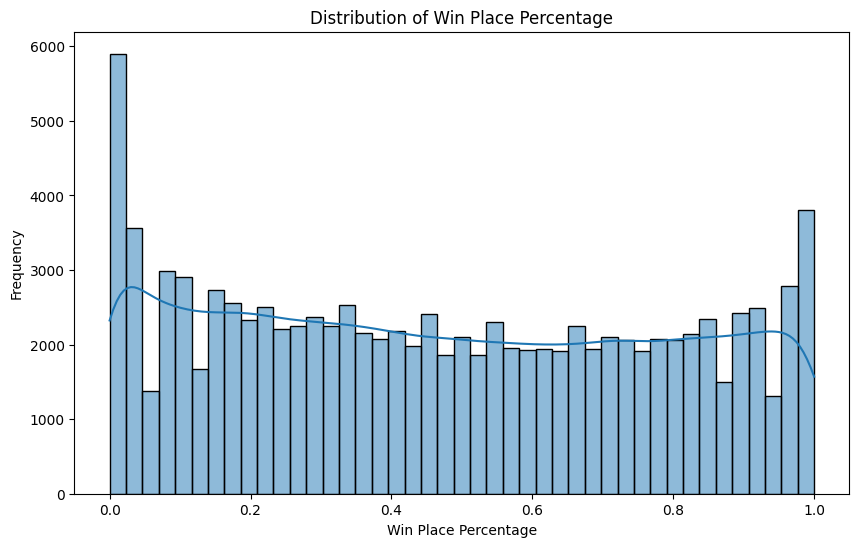

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df.sample(100000, random_state=random_state)['winPlacePerc'], kde=True)
plt.title('Distribution of Win Place Percentage')
plt.xlabel('Win Place Percentage')
plt.ylabel('Frequency')
plt.show()

There are large spikes at 0 (early deaths) and 1 (winners), with a relatively uniform middle, which reflects the general player base well. Some things to note:
- When selecting our loss function, we should choose something like MAE (Mean Absolute Error) or Huber Loss, as they do not penalize the common extremes like MSE. 
- We should track errors separately for early deaths (0-0.2), middle-of-the-road players (0.2-0.8) and survivors (0.8-1.0). 
- The bimodal nature suggests ensemble methods might work well (different models for different placement ranges)

#### Missing Data Analysis

Any model is unable to handle missing values, so we must come up with strategies to remove them when pre-processing. Here we run a check to see which columns have empty values. 

In [12]:
df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

Only `winPlacePerc` has a missing value, and since this is our target, this row is not going to be useful to us in any way. We will make a note to drop this in preprocessing. 

One interesting aspect of our data is that among 4.4M rows, having only one missing value is exceptionally rare, especially in real-world datasets!

#### Feature Scales

Since we're running a linear model, standardization is required as they are sensitive to scale changes. Here, we define the scale ratio as the ration between the max standard deviation and the min standard deviation. 

In [13]:
# Here we choose a representative sample of features across different scales
# You can adjust the number of features selected as needed
# from only a few features to all features

scales = df[num_cols].std().sort_values(ascending=False)

high_scale = scales.head(2).index.tolist() 
mid_scale = scales[len(scales)//2:len(scales)//2+2].index.tolist()
low_scale = scales.tail(2).index.tolist()

sample_features = high_scale + mid_scale + low_scale

feature_stats = df[sample_features].describe()
print(feature_stats.loc[['mean', 'std', 'min', 'max']])
scales = feature_stats.loc['std']
print(f"\nScale ratio (max std / min std): {scales.max() / scales.min():.1f}x")
if scales.max() / scales.min() > 100:
    print("Features have vastly different scales; consider standardization")
else:
    print("Feature scales are relatively similar")

      rideDistance  walkDistance      heals  weaponsAcquired  vehicleDestroys  \
mean    606.115669   1154.217859   1.370147         3.660488         0.007918   
std    1498.343513   1183.497042   2.679982         2.456544         0.092612   
min       0.000000      0.000000   0.000000         0.000000         0.000000   
max   40710.000000  25780.000000  80.000000       236.000000         5.000000   

      roadKills  
mean   0.003496  
std    0.073373  
min    0.000000  
max   18.000000  

Scale ratio (max std / min std): 20420.9x
Features have vastly different scales; consider standardization


No matter what sample is used, the scale ratio is high, and that makes sense. We have some features that are in the form of thousands of meters like `walkDistance`, some that are in the form of hundreds like `damageDealt`, and some that are in the tens or below ten like `kills`. The scale is wildly different between metrics, so standardization using `StandardScaler` is necessary, or else some features like `walkDistance` will dominate. 

#### Univariate Distributions (numerical)

Now let's work to better understand our features. Here, we create histograms for some sample features, and examine distribution shapes. By doing this we can identify any skewness, zero-inflation, or potential data quality issues that may need transformation or special handling, and just in general understand typical value ranges. 

<Figure size 1800x1000 with 0 Axes>

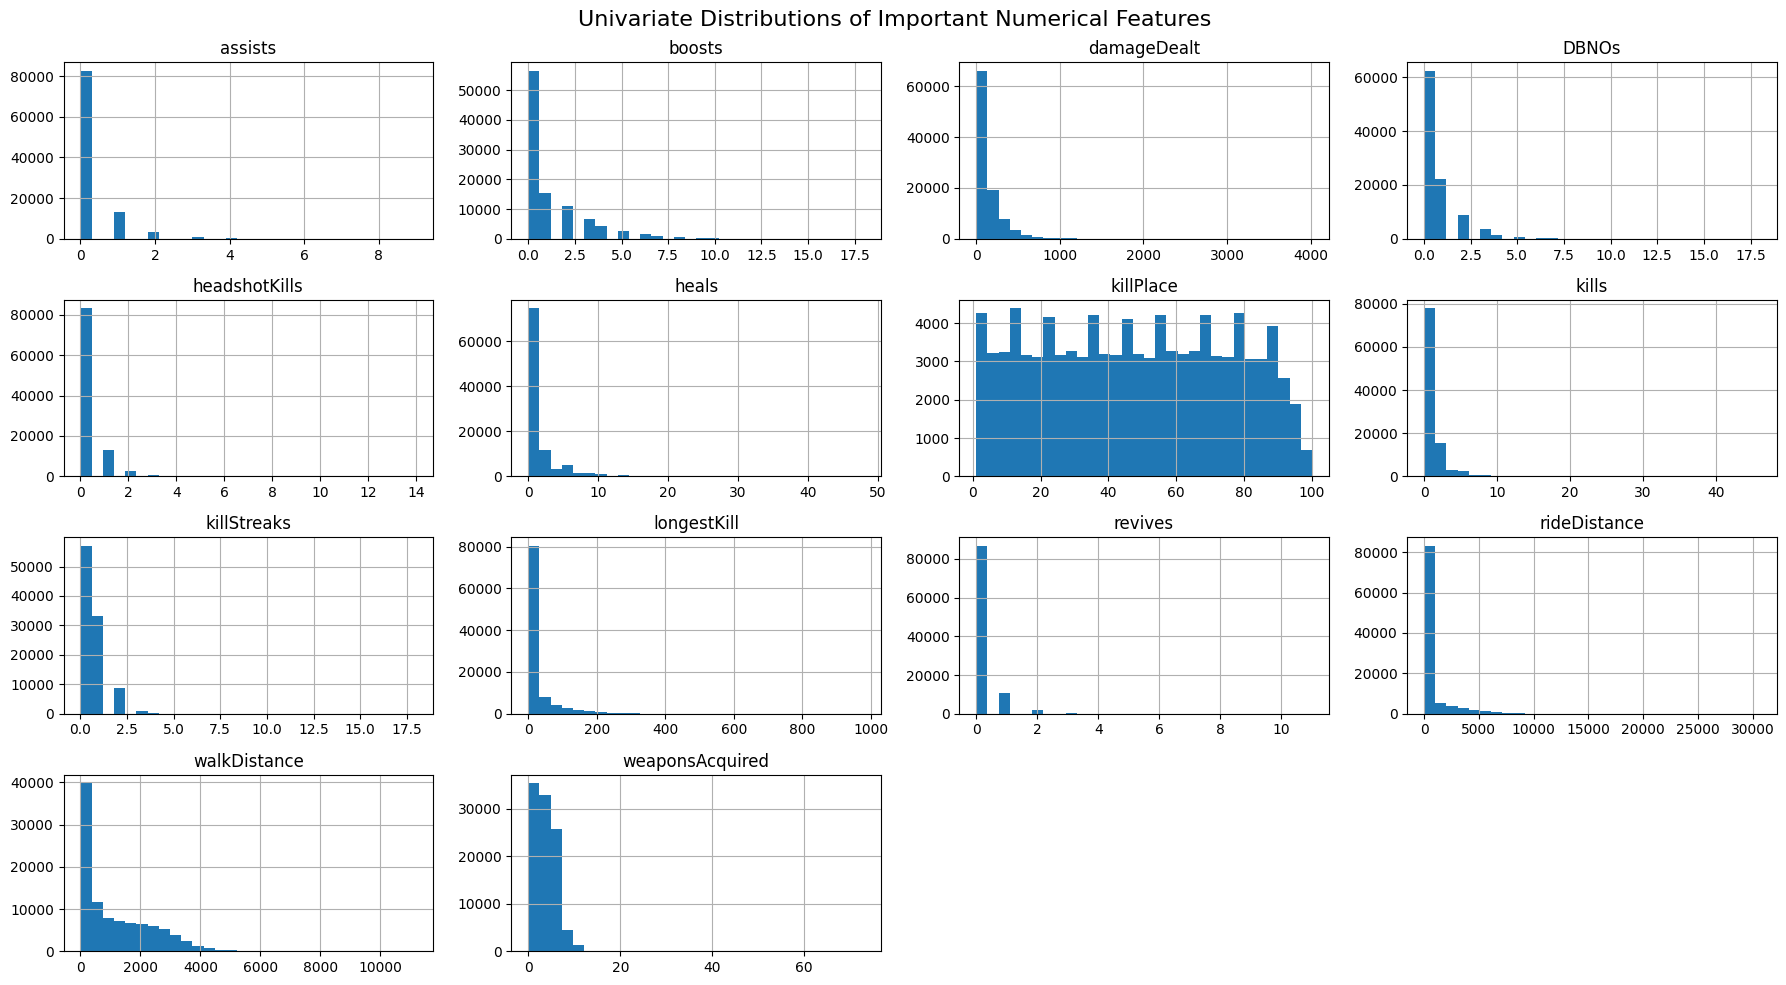

In [14]:
# This is just a way to sample important features for visualization
# You can choose different thresholds or methods to select important features
# Or go all out and select all features if desired
corr_with_target = df[num_cols].corr()['winPlacePerc'].drop('winPlacePerc')
important_cols = corr_with_target[abs(corr_with_target) > 0.15].index.tolist()

plt.figure(figsize=(18,10))
df.sample(100000, random_state=random_state)[important_cols].hist(figsize=(18,10), bins=30)
plt.suptitle('Univariate Distributions of Important Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

Our the bat most, if not all, features have an extreme right skew, all clustered in the first half/quarter range. This makes sense, as most players die incredibly early without much action. We also identify some discrete features like `kills`, `boosts`, and `heals`, and some continuous featues like `walkDistance` and `rideDistance`. 

Skewed metrics would need log transformation applied to even them out. Let us grab a list of candidates we can use to transform later. 

In [15]:
skewness = df[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_features = skewness[skewness > 2].index.tolist() # here we select features with skewness > 2
print(f"\nSkew Candidates: {skewed_features}")


Skew Candidates: ['roadKills', 'swimDistance', 'vehicleDestroys', 'teamKills', 'headshotKills', 'revives', 'longestKill', 'assists', 'heals', 'kills', 'rideDistance', 'DBNOs', 'damageDealt', 'weaponsAcquired']


Zero-inflated features refer to features that have a huge amount of zeroes than any other metric, for example, `heals` and  `kills`, as players not doing any of these is much more common than players using any of them. To handle them, we can note these options as feature-engineering candidates for binary flags, like `has_kills` and `used_heals`. 

#### Match Type Distribution (categorical)

Match type is definitely a feature we will be encoding later, so let's take the time to analyze the different match types to see how often people play these. This can help identify any class imbalance and prevent us from making any assumptions on category correlation with winRates just because of play frequency. 

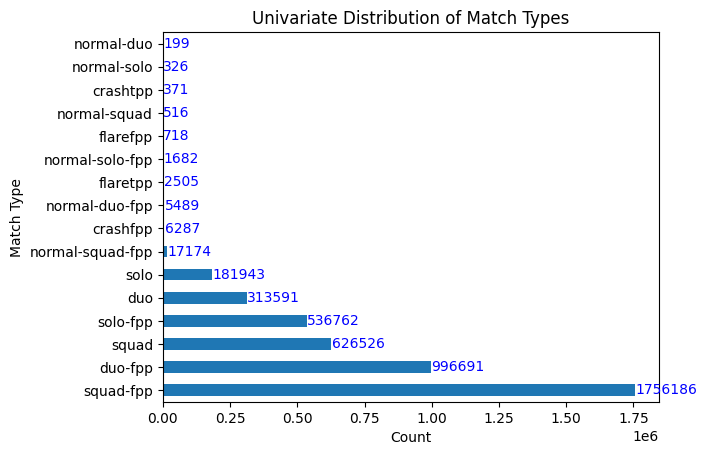

In [16]:
df['matchType'].value_counts().plot(kind='barh')
for i, v in enumerate(df['matchType'].value_counts()):
    plt.text(v + 1000, i, str(v), color='blue', va='center')
plt.xlabel('Count')
plt.ylabel('Match Type')
plt.title('Univariate Distribution of Match Types')
plt.show()

Immediately we have some dominant categories, like `squad-fpp`, `duo-fpp`, and `solo-fpp`, with many other categories barely getting recognized (like in 4.4M games, only 199 use `normal-duo`? That will get overrepresented had we not done this check). 
There are also 16 categories, too many for one-hot encoding, which is not even worth it due to the sparseness. The imbalance is natural, but there are other ways to encode this data without resampling or removing it:
- **Target Encoding**: We replace the category with the mean `winPlacePerc` for that category. This efficiently handles category importances.
- **Grouped Encoding**: There are some ways we can group them, ike perspective (FPP vs TPP), team size (solo vs duo vs squad), or mode (normal/crash/flare).
- **One-hot endcoding**: Clearly we have a top 5-6 that is most played (>150K), so we group the rest as other and one-hot encode into 6-7 rows.

For the sake of this analysis, we will proceed with **target encoding**. Analysts are encouraged to experiment with any other method to see if they affect results. 

### Relationships and Quality

#### Bivariate Distribution Analysis

Here, we'll try to get a stronger idea of feature-target relationships. We can identify outliers, unusual patterns, variance changes across range (heteroscedasticity), and discrete vs continuous patterns. 

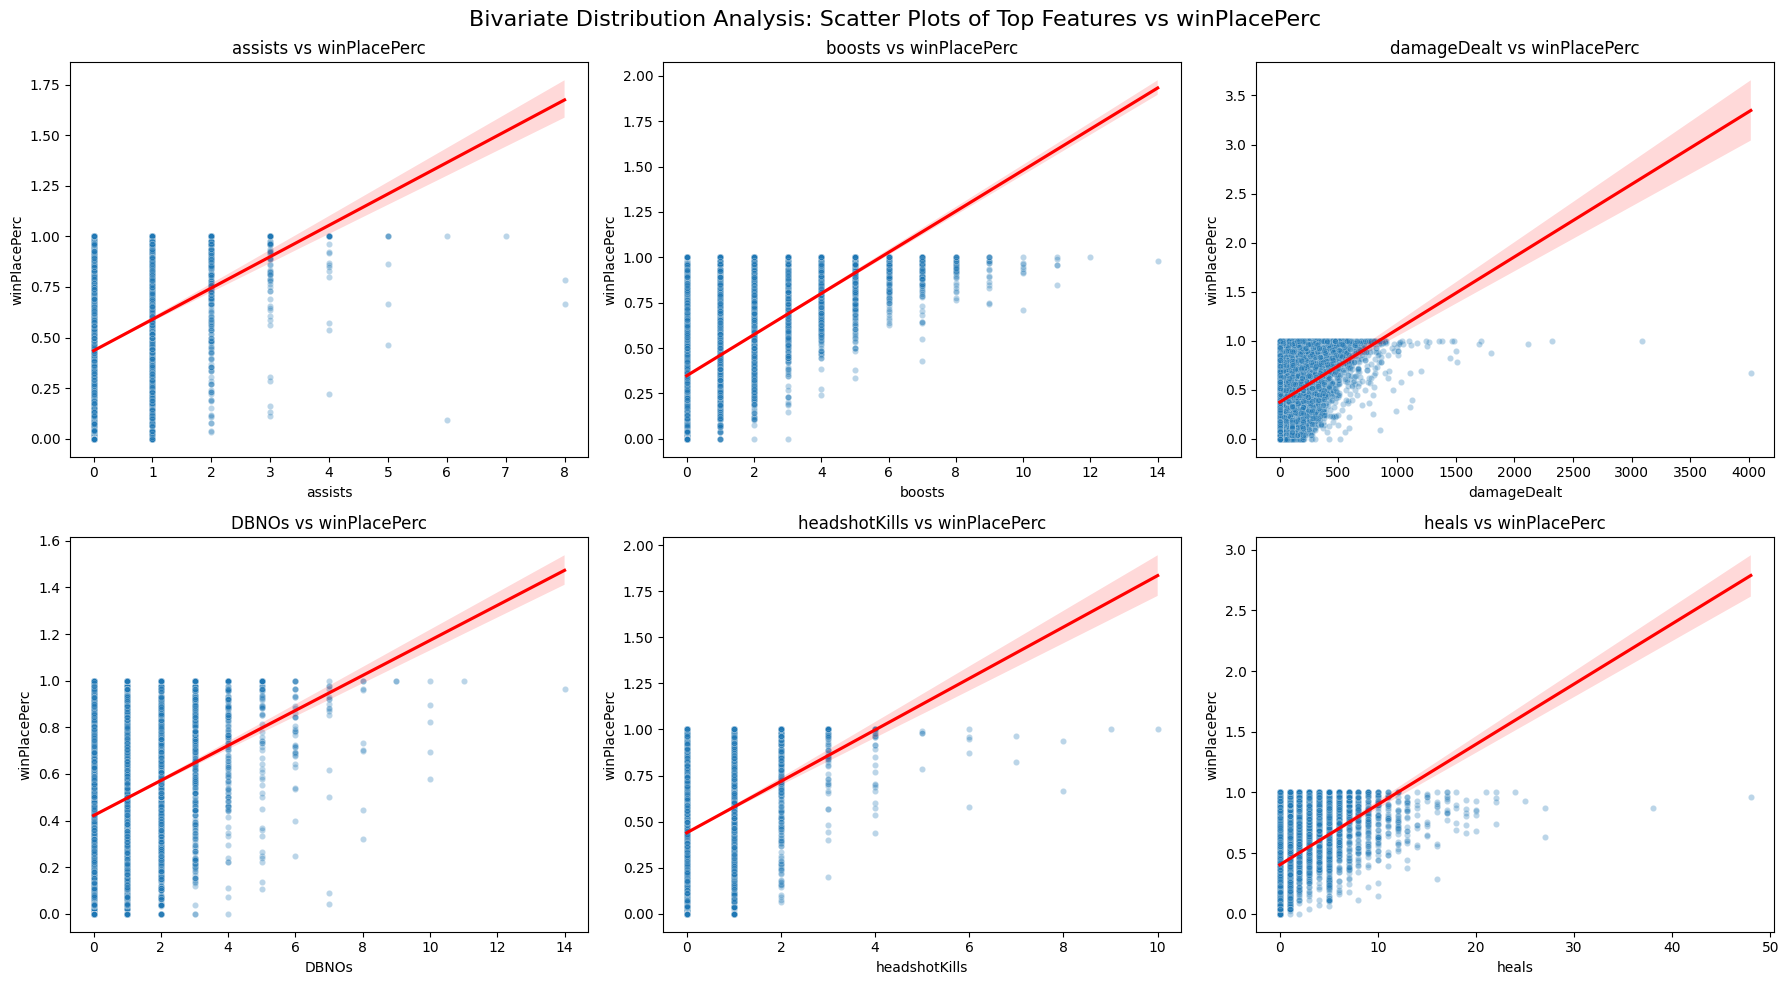

In [17]:
# Focusing on top 6 features by absolute correlation with target
top_features = corr_with_target.head(6).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, feature in zip(axes.flatten(), top_features):
    sns.scatterplot(
        data=df.sample(10000, random_state=random_state),
        x=feature, y='winPlacePerc',
        alpha=0.3, s=20, ax=ax
    )
    sns.regplot(
        data=df.sample(10000, random_state=random_state),
        x=feature, y='winPlacePerc',
        scatter=False, color='red', ax=ax
    )
    ax.set_title(f'{feature} vs winPlacePerc')
plt.suptitle('Bivariate Distribution Analysis: Scatter Plots of Top Features vs winPlacePerc', fontsize=16)
plt.tight_layout()
plt.show()


Except for `killPlace` (which makes sense, lower kill rank (1=most kills) → better placement), all features show positive relationships with `winPlacePerc`. `walkDistance` is the best by far, with a strong linear positve relationship, proving to be the best feature by far. Most relationships are linear, which is good for linear regression. 

Notably, `damageDealt` has a fan-shape regression line, showing increased variance as `winPlacePerc` goes up. This means `damageDealt` is heteroscedastic. It shows that some high-damage players still lose, possibly to zone/team. For linear models, we should consider weighted least squares, though tree models like RandomForestRegressor handle this naturally. 

Metrics like `boosts`, `weaponsAcquired`, and `heals` show visible banding due to their discrete nature. These shouldn't be normalized excessively, but we can also consider polynomial features to capture non-linearity. 

#### Outlier and Data Quality Check

In a popular battle royale game like PUBG, there are various different play styles from casual to skilled to computer-assisted gaming. We want to do a comprehensive screening to check for any extreme values, and any to keep vs remove. 

C:\Users\dgane\AppData\Local\Temp\ipykernel_43272\1012065655.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dgane\AppData\Local\Temp\ipykernel_43272\1012065655.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dgane\AppData\Local\Temp\ipykernel_43272\1012065655.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dgane\AppData\Local\Temp\ipykernel_43272\1012065655.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotat

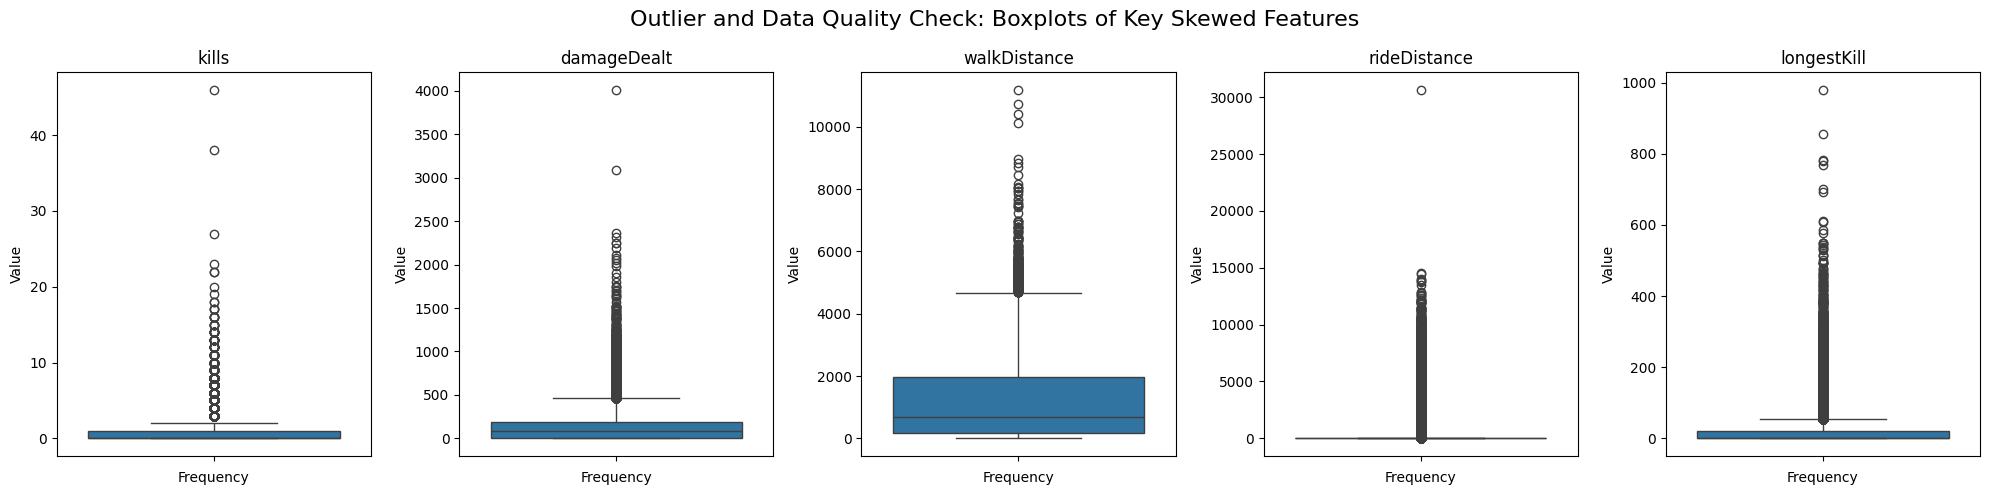

In [18]:
df[num_cols].max().sort_values(ascending=False).head(10)
df[num_cols].min().sort_values().head(10)

# Boxplots for key skewed features
# Here we choose some features that from domain knowledge will probably have outliers
# But you are encouraged to explore other features as well 
key_features = ['kills', 'damageDealt', 'walkDistance', 'rideDistance', 'longestKill']

fig, axes = plt.subplots(1, len(key_features), figsize=(20, 5))
for ax, feature in zip(axes, key_features):
    sns.boxplot(data=df.sample(50000, random_state=random_state), y=feature, ax=ax)
    ax.set_title(feature)
    ax.set_ylabel('Value')
    ax.set_xlabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.suptitle('Outlier and Data Quality Check: Boxplots of Key Skewed Features', fontsize=16)
plt.tight_layout()
plt.show()


Out the bat we have a suspicious metric: `kills`. The upper whisker only has seven kills, and while it's possible for this metric to be zero or under-tens inflated due to strategies like camping, the sparseness of the higher level outliers, such as 72, indicates strategies that involve computer-assited gaming. Including these in our analysis would undervalue the human players who our analysis targets. This metric would benefit from further EDA analysis. 

##### Outlier Investigation: Kills vs Match Duration

We start by plotting kills associated with the `matchDuration`, to investigate if these extreme kills are legitimate. If they occur in a short time, that's cheating and should be handled. 

c:\Users\dgane\miniconda3\envs\itcs-3162\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


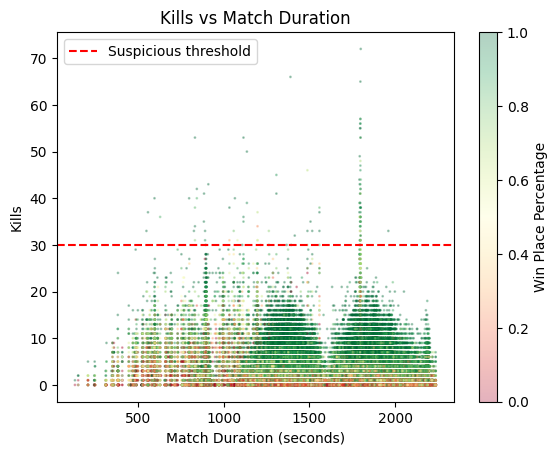

In [19]:
plt.scatter(df['matchDuration'], df['kills'], 
                c=df['winPlacePerc'], cmap='RdYlGn', 
                alpha=0.3, s=1)
plt.axhline(y=30, color='r', linestyle='--', label='Suspicious threshold')
plt.xlabel('Match Duration (seconds)')
plt.ylabel('Kills')
plt.title('Kills vs Match Duration')
plt.legend()
plt.colorbar(label='Win Place Percentage')
plt.show()

Most players cluster around 0-10 kills across all match durations, and extreme kills between 30-72 exist. There is a suspicious pattern thorough: some 40+ kills happen in matches under 1500 seconds - thats >1.5 kills per minute sustained, which is unrealistic. Our next analysis will then have to focus on kills per minute. 

##### Outlier Validation: Kills per Minute

Kills per minute can give us a much cleaner picture of whether a player is playing computer-assisted or not. Here we define 'suspicious` as having more than one kill per minute on a game, though analyst can change that as needed. 

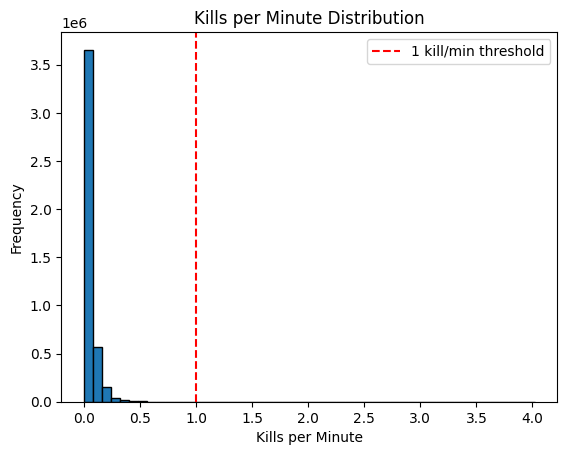

In [20]:
kills_per_minute = df['kills'] / (df['matchDuration'] / 60)
extreme_killers = df[df['kills'] > 30].copy()

plt.hist(kills_per_minute, bins=50, edgecolor='black')
plt.axvline(x=1.0, color='r', linestyle='--', label='1 kill/min threshold')
plt.xlabel('Kills per Minute')
plt.ylabel('Frequency')
plt.title('Kills per Minute Distribution')
plt.legend()
extreme_killers_display = extreme_killers[['Id', 'kills', 'matchDuration', 'winPlacePerc']]
extreme_killers_display.reset_index(drop=True, inplace=True)
plt.show()

There's an extreme right skew, with most players getting < 0.2 kills per minute, expected of any average player and confirming our hypothesis. While not visible in our histogram, there should be a small number of players with kills per minute > 1.0, as established earlier. We can calculate the percentage of suspicious players as below: 

In [21]:
is_suspicious = (kills_per_minute > 1.5) | (df['kills'] > 40)
print(f"Suspicious records: {is_suspicious.sum()} ({is_suspicious.mean()*100}%)")

Suspicious records: 212 (0.004767295275025714%)


We can consider these records as outliers caused by computer-assisted gameplay or errors and therefore can be safely removed. 

### Feature Engineering Decisions

#### Multicollinearity Analysis

One important analysis we have to make before modeling is a **multicollinearity** check. Multicollinearity is when two features are closely related that if you have the value of one, you can derive the other. This can be a problem as including too many multicollinear features can lead to model instability, as variances in one could reflect in multicollinear features, leading changes in these to cause swings in model predictions. 

We will use Variance Inflation Factor testing to measure how much of a feature's variance is inflated due to correlation with other features. This is better than a simple correlation check through a heatmap as it can tell us how problematic the correlation could be. 

VIF(feature_i) = 1 / (1 - R²_i)

Where R²_i = how well feature_i can be predicted from all OTHER features. 

- VIF = 1: No correlation with other features (perfect!)
- VIF = 5: Moderate correlation (acceptable)
- VIF = 10: High correlation (concerning for linear models)
- VIF = ∞: Perfect correlation (feature is redundant)

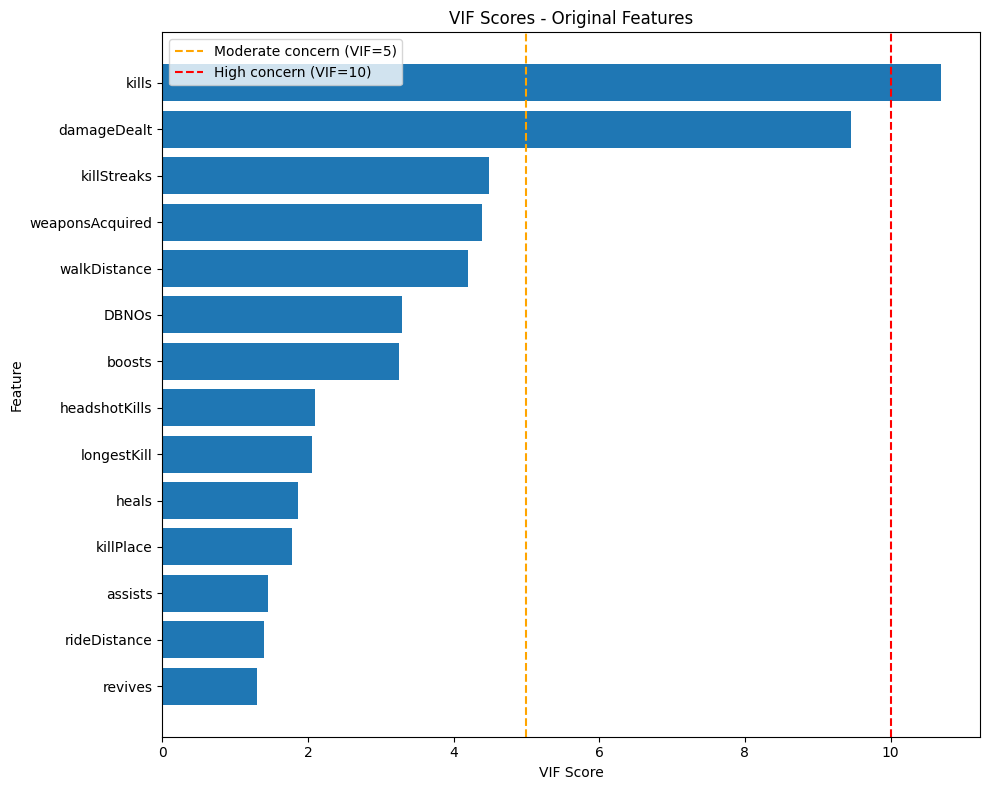

In [22]:
# Define feature sets
features_original = [col for col in num_cols if col not in [
    'winPlacePerc', 'matchDuration', 'maxPlace', 'numGroups'
]]
features_original = [col for col in features_original if col not in corr_with_target[abs(corr_with_target) < 0.15].index.tolist()]

def calculate_vif(data, features):
    X = data[features].fillna(0)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]
    return vif_data.sort_values('VIF', ascending=False)

vif_original = calculate_vif(df.sample(100000, random_state=random_state), features_original)
# VIF is stable, as feature correlations dont change much with sample size

plt.figure(figsize=(10, 8))
plt.barh(vif_original['Feature'], vif_original['VIF'])
plt.axvline(x=5, color='orange', linestyle='--', label='Moderate concern (VIF=5)')
plt.axvline(x=10, color='r', linestyle='--', label='High concern (VIF=10)')
plt.xlabel('VIF Score')
plt.ylabel('Feature')
plt.title('VIF Scores - Original Features')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

We chose to exclude some features right off the bat because they are either:
- the target
- features that aren't related to player performance
- have very low collinearity with the target (<0.15)

But right off the bat, we have issues. `kills` is well above the concerning threshold. `damageDealt` is above acceptable, but is also not far behind the concerning range. This is because these two are strongly correlated with each other, but also metrics like `killStreaks` (more kills=higher streaks), `headshotKills` (subset of kills), `DBNOs` (knock down before kill), and `assists` (in squad play, kills correlate with assists). 

Clearly some features need to be removed. Let's generate various features that correlate with kills to see which ones can be removed. 

C:\Users\dgane\AppData\Local\Temp\ipykernel_43272\2749740041.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kills_correlations.values, y=kills_correlations.index, palette='coolwarm')


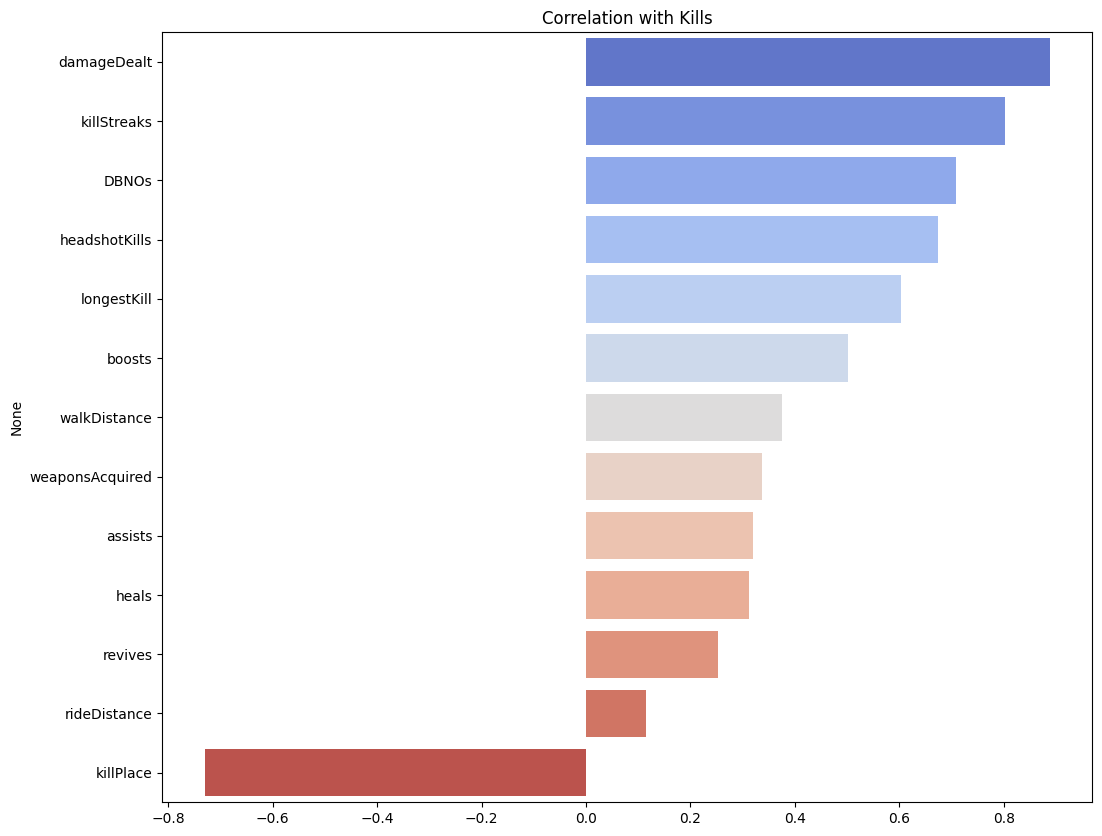

In [23]:
corr_matrix = df[features_original].corr()
plt.figure(figsize=(12, 10))
kills_correlations = corr_matrix['kills'].drop('kills').sort_values(ascending=False)
sns.barplot(x=kills_correlations.values, y=kills_correlations.index, palette='coolwarm')
plt.title("Correlation with Kills")
plt.show()

Our top 5 candidates, most related to `kills`, are in the bar chart. While `damageDealt` has high correlation with `kills`, it also provides more unique information on its own too. So let's keep it while dropping the other four. 

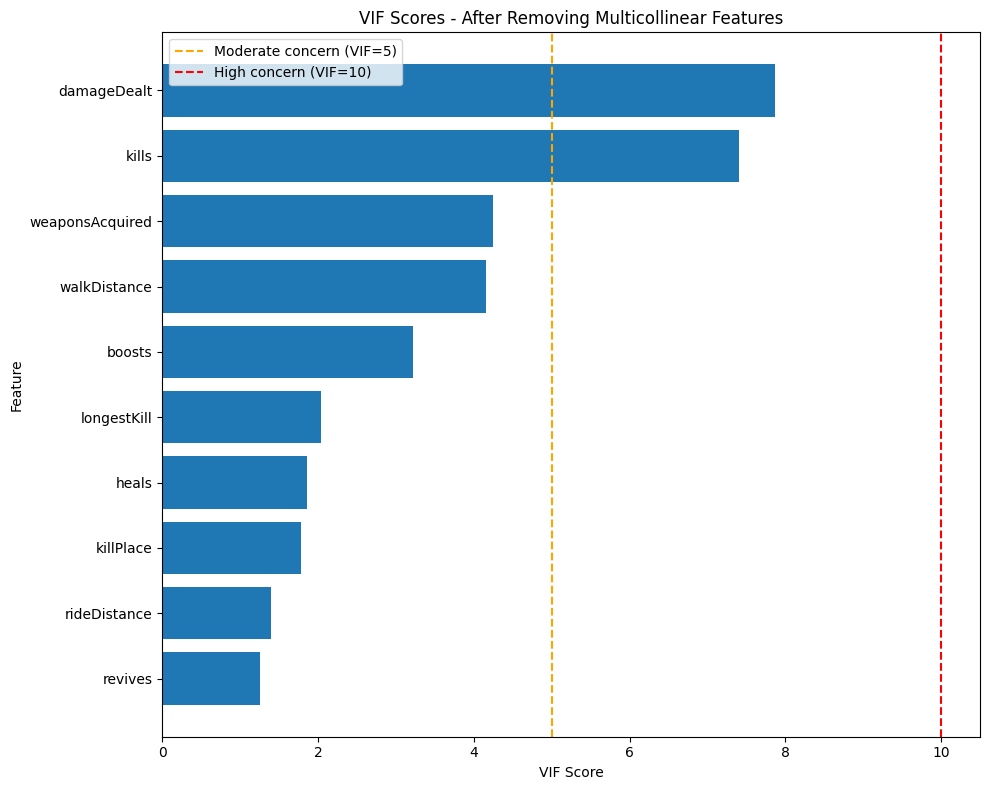

In [24]:
features_cleaned = [col for col in features_original if col not in [
    'killStreaks', 'headshotKills', 'DBNOs', 'assists'
]]
vif_cleaned = calculate_vif(df.sample(100000, random_state=random_state), features_cleaned)
# VIF is stable, as feature correlations dont change much with sample size

plt.figure(figsize=(10, 8))
plt.barh(vif_cleaned['Feature'], vif_cleaned['VIF'])
plt.axvline(x=5, color='orange', linestyle='--', label='Moderate concern (VIF=5)')
plt.axvline(x=10, color='r', linestyle='--', label='High concern (VIF=10)')
plt.xlabel('VIF Score')
plt.ylabel('Feature')
plt.title('VIF Scores - After Removing Multicollinear Features')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Much better! `damageDealt` and `kills` are now just above the acceptable range, which is fine, while the others are in the green. We will keep in mind to remove these features during the pre-processing pipeline. 

#### Match-Type Stratification

Focusing on the top 5 match types, we now calculate feature-target correlations separately for each. We use this to identify if we need separate models for differnet match types and look out for any interaction effects. 

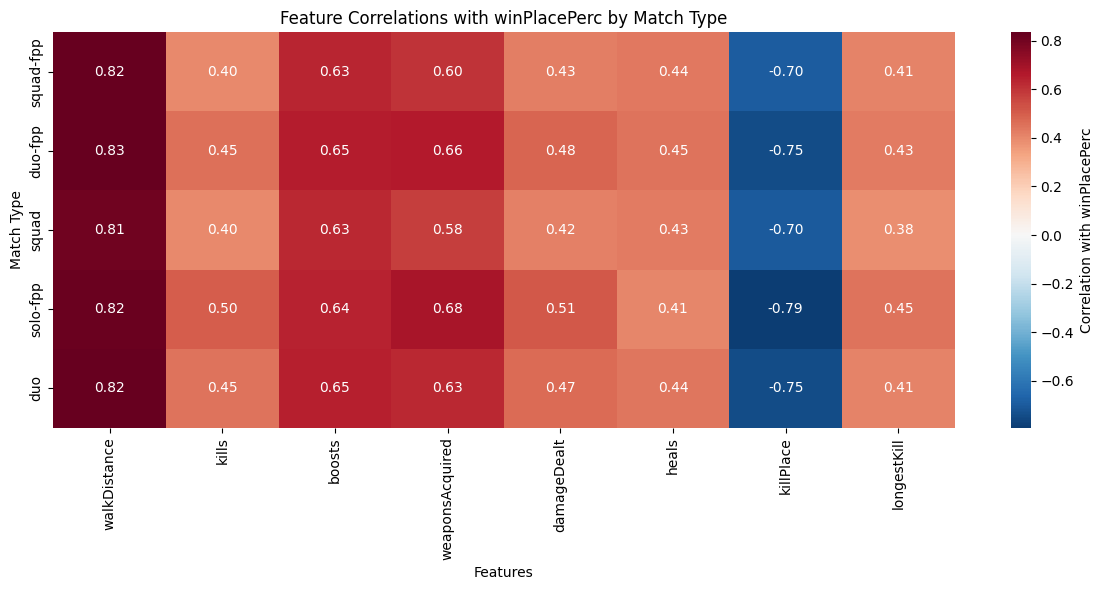

In [25]:
top_match_types = df['matchType'].value_counts().head(5).index
correlation_by_match = {}
features_to_check = ['walkDistance', 'kills', 'boosts', 'weaponsAcquired', 
                     'damageDealt', 'heals', 'killPlace', 'longestKill']

for match_type in top_match_types:
    match_data = df[df['matchType'] == match_type]
    correlations = match_data[features_to_check + ['winPlacePerc']].corr()['winPlacePerc'].drop('winPlacePerc')
    correlation_by_match[match_type] = correlations

corr_df = pd.DataFrame(correlation_by_match).T

plt.figure(figsize=(12, 6))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation with winPlacePerc'})
plt.title('Feature Correlations with winPlacePerc by Match Type')
plt.xlabel('Features')
plt.ylabel('Match Type')
plt.tight_layout()
plt.show()


Some features are stable, some have a good amount of variance. `walkDistance`, `boosts`, and `heals` have low variance, while all the killing variables have higher variance. Observing just `kills`, `weaponsAcquired`, `damageDealt`, `killPlace`, and `longestKill`, the strongest correlations are made in solo matches, where individual skill matters most, and less in duo and squad matches, where team play can dilute individual stats. The differences are rather moderate though, and the variance is not very high. 

A single model at a time is fine, and matchType can be kept as a feature (with Target encoding as mentioned earlier). Models may predict slightly worse for squad modes though, which should be expected and is fine in the long-run. 

#### Log-Transform Visualization & Correlation Impact

When we performed univariate analysis, there were several features that were right-skewed, so now's the chance to log1p transform them to see if the normalizations can improve distribution shape. 

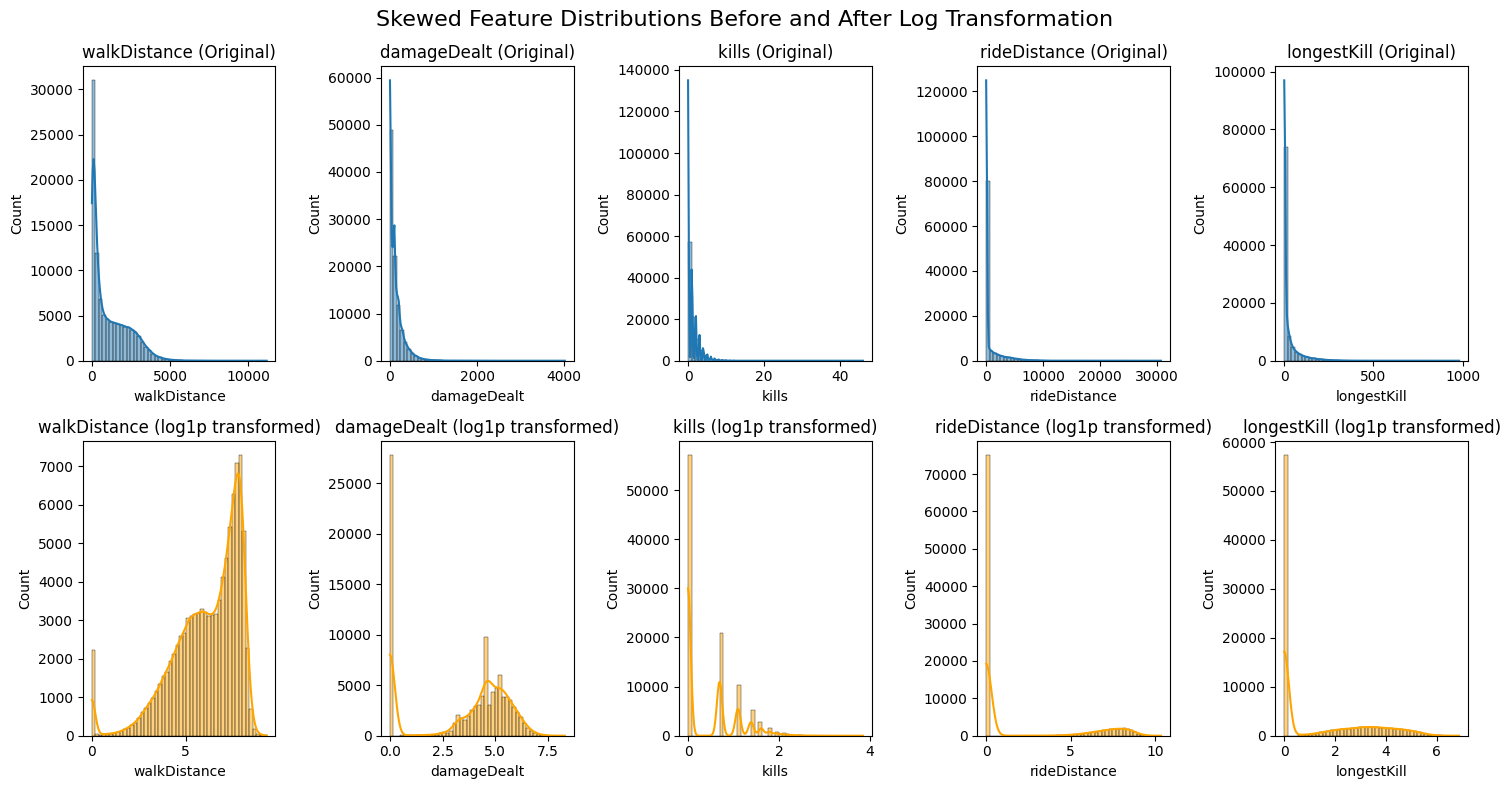

In [26]:
skewed_features = ['walkDistance', 'damageDealt', 'kills', 'rideDistance', 'longestKill']

fig, axes = plt.subplots(2, len(skewed_features), figsize=(15, 8))
for i, feature in enumerate(skewed_features):
    sns.histplot(df.sample(100000, random_state=random_state)[feature], bins=50, ax=axes[0, i], kde=True)
    axes[0, i].set_title(f'{feature} (Original)')
    
    # Log transform safely (add small epsilon to avoid log(0))
    sns.histplot(np.log1p(df.sample(100000, random_state=random_state)[feature]), bins=50, ax=axes[1, i], kde=True, color='orange')
    axes[1, i].set_title(f'{feature} (log1p transformed)')
plt.suptitle('Skewed Feature Distributions Before and After Log Transformation', fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
print("=== TRANSFORMATION IMPACT ON CORRELATION ===")
transform_features = ['walkDistance', 'damageDealt', 'kills', 'rideDistance', 'longestKill']

for feature in transform_features:
    corr_original = df[[feature, 'winPlacePerc']].corr().iloc[0, 1]
    corr_log = np.log1p(df[feature]).corr(df['winPlacePerc'])
    improvement = corr_log - corr_original
    is_improved = improvement > 0.05

    print(f"{feature:20s}: Original={corr_original:.3f}, Log={corr_log:.3f}, Δ={improvement:+.3f}, Improved={is_improved}")

=== TRANSFORMATION IMPACT ON CORRELATION ===
walkDistance        : Original=0.811, Log=0.795, Δ=-0.016, Improved=False
damageDealt         : Original=0.441, Log=0.401, Δ=-0.039, Improved=False
kills               : Original=0.420, Log=0.449, Δ=+0.029, Improved=False
rideDistance        : Original=0.343, Log=0.427, Δ=+0.084, Improved=True
longestKill         : Original=0.410, Log=0.474, Δ=+0.064, Improved=True


`longestKill` and `rideDistance` seem to benefit from log transformation. This makes sense, as the two originally follow a pattern something like this for `rideDistance`:
  - 0m → low placement
  - 100m → slightly better
  - 5,000m → much better
  - 20,000m → not much more improvement
This is very non-linear in nature - at a certain point you don't improve much. This isn't so much the case with other metrics, which are core to the game. We will make a note of the two for log transformation when preprocessing. 

#### Feature-Target Correlation

Now we identify how correlated a target is to the feature. This correlation is one-to-one, meaning if we take just a feature and `winPlacePerc` and ignored the rest, how strong does this feature correlate to the target, which is our proxy for predictive power? If a feature is strong, there is a good chance it will be represented highly in our linear models. If not, it may be safe to drop it. We also can identify which features to prioritize with feature engineering. 

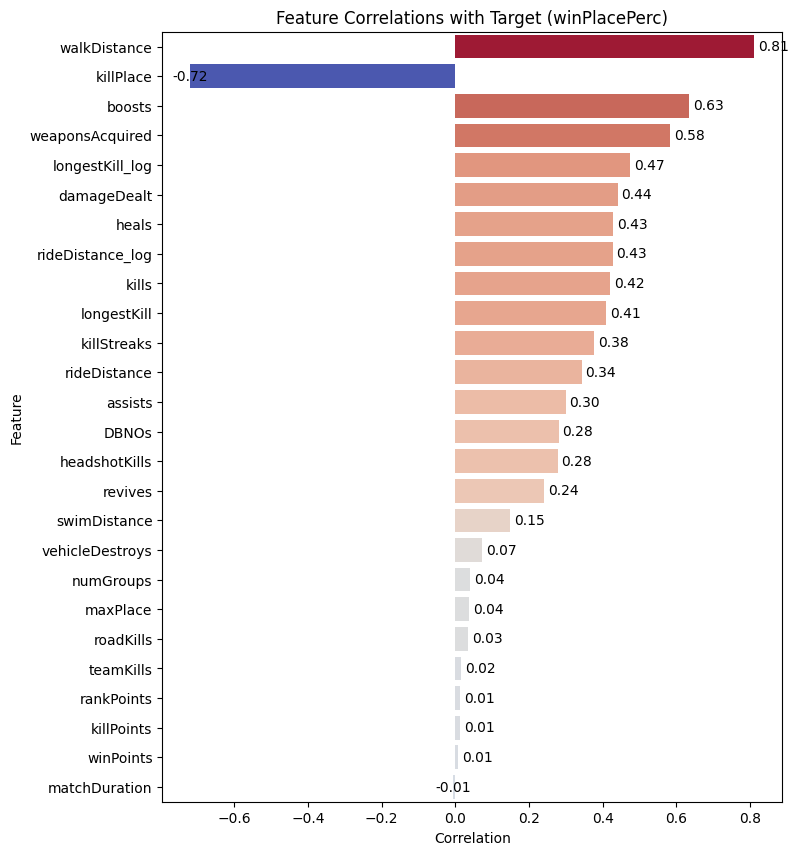

In [35]:
# Let's add log transformed features for rideDistance and longestKill to correlation plot
corr_with_target_log_updated = corr_with_target.copy()
corr_with_target_log_updated['rideDistance_log'] = np.log1p(df['rideDistance']).corr(df['winPlacePerc'])
corr_with_target_log_updated['longestKill_log'] = np.log1p(df['longestKill']).corr(df['winPlacePerc'])
corr_with_target_log_updated = corr_with_target_log_updated.sort_values(key=abs, ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(
    x=corr_with_target_log_updated,
    y=corr_with_target_log_updated.index,
    palette='coolwarm',
    hue=corr_with_target_log_updated,
    legend=False
)
for i, v in enumerate(corr_with_target_log_updated):
    plt.text(v + 0.01 if v > 0 else v - 0.05, i, f"{v:.2f}", color='black', va='center')
plt.title('Feature Correlations with Target (winPlacePerc)')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.show()


Time and time again, this graph emphasizes `walkDistance` as our MVP, since it indicates length of survival. Right now, it will be safe to drop weak features of |r| < 0.05 as they add noise without signal. Our log transformed features did incredibly well, saving `rideDistance` and `longestKill` from dropping. We should also consider interactions around `walkDistance` too. 

### Final Validation

#### Data Leakage Check

Feature leakage refers to the introduction of information about the target variable that should not be legitimately available during the modeling process. This is often called due to premature featurization - we don't know what exactly goes down behind a feature, and it may be engineered as a proxy for our target. Introducing this feature may lead to over optimisitic yet inaccurate models. 

The main thing we want to check here is

**`killPlace`: Rank of kills - is this calculated POST-match?**

`killPlace` has consistently scored high correlation with the target, and according to Kaggle, `killPlace` is the ranking in match of number of enemy players killed. This makes this feature seem not like an in-match metric, but a ranking post-game deriving from in-game performance. This gives `killPlace` a huge boost if the leakage is true. Let's confirm that. 

In [41]:
# Pick a random match
sample_match = df['matchId'].iloc[0]
match_data = df[df['matchId'] == sample_match].copy()

print(f"Match ID: {sample_match}")
print(f"Players in this match: {len(match_data)}")
print(f"\nkillPlace distribution in this match:")
print(match_data['killPlace'].value_counts().sort_index().head(20))
print(f"\nkillPlace range in this match: {match_data['killPlace'].min()} to {match_data['killPlace'].max()}")

# If killPlace goes from 1 to N (where N = players in match), it's LEAKAGE
# If all players have similar killPlace values, it might be global ranking

Match ID: a10357fd1a4a91
Players in this match: 96

killPlace distribution in this match:
killPlace
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
Name: count, dtype: int64

killPlace range in this match: 1 to 96


Each `killPlace` from 1-20 has 1 count. If we keep going, there's actually one count for each `killPlace` in the overall game. This suggests that `killPlace` is a huge concern for data leakage, and must be removed. 